### OpAmp Bode Template

Notes: <br>
1. Resistance and capacitance designators do not correspond to designators in Altium schematic <br>
   1. THIS WAS CORRECTED IN OUR CODE.
2. Pay attention to the comments<br>
3. All component values have been set to one by default <br>

c:\Users\Steven\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


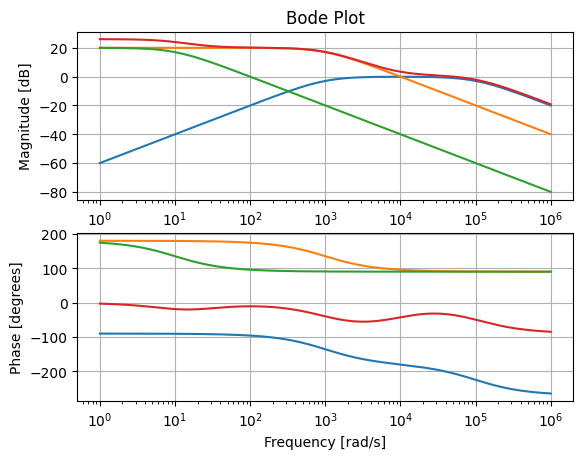

In [2]:
#import packages, pip install as necessary
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Resistor and Cap values have been adjusted to Altium schematic 

#Differentiator stage terms
R14 = 1e3  #feedback resistor, Ohms
R15 = 1e3 #input resistor, Ohms
C20 = 1e-6 #capacitor in series with R1, Farads
C19 = 1e-8 #optional capacitor in parallel with R2, Farads
Gd = -1  #follow on summer gain, V/V
 
#Proportional stage terms
R3 = 1e3 #input resistor, Ohms
R5 = 1e4 #feedback resistor, Ohms
C6 = 1e-7 #capacitor in parallel with R5, Farads
Gp = -1 #follow on summer gain, V/V

#Realistic integrator terms
#...realistic means a feedback resistor is included to limit the integrator gain and associated DC errors
R8 = 1e4 #input resistor, Ohms
R26 = 1e5 #feedback resistor, Ohms
C7 = 1e-6 #feeback capacitor, in parallel with R26, Farads
Gi = -1  #follow on summer gain, V/V

# Calculate differentiator transfer function
#EXAMPLE provided for differentiator only, user to adapt to proportional and integral terms
num_d = np.array([0, -C20*R14,0])  #numerator of transfer function
den_d = np.array([C19*C20*R14*R15,C20*R15+C19*R14,1])  #denominator of transfer function
D = signal.TransferFunction(num_d, den_d)  # Create s variable for Laplace domain

# Calculate porportional transfer function
# USER must update numerator and denominator
num_p = np.array([0, 0, -R5])
den_p = np.array([0, R5*R3*C6, R3])
P = signal.TransferFunction(num_p, den_p)  # Create s variable for Laplace domain

# Calculate integral transfer function
# USER must update numerator and denominator
num_i = np.array([0, 0, -R26])
den_i = np.array([0, R8*R26*C7, R8])
I = signal.TransferFunction(num_i, den_i)  # Create s variable for Laplace domain

#full PID contains terms summed, with opamp summer stage Gx  
num_pid1 = Gd*np.convolve(num_d, den_p)
num_pid1 = np.convolve(num_pid1, den_i) 
#--
num_pid2 = Gp*np.convolve(num_p, den_i)
num_pid2 = np.convolve(num_pid2, den_d)
#--
num_pid3 = Gi*np.convolve(num_i, den_d)
num_pid3 = np.convolve(num_pid3, den_p)
#--
num_pid = num_pid1 + num_pid2 + num_pid3
#--
den_pid = np.convolve(den_d, den_p)
den_pid = np.convolve(den_pid, den_i)   

PID = signal.TransferFunction(num_pid, den_pid) 

# Generate frequency points
omega = np.logspace(0, 6, 500)  # Frequency range from 0.1 to 100 rad/s

# Calculate Bode data
omega, mag_d, phase_d = signal.bode(D, omega)
omega, mag_p, phase_p = signal.bode(P, omega)
omega, mag_i, phase_i = signal.bode(I, omega)
omega, mag_pid, phase_pid = signal.bode(PID, omega)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1)
freq = omega/(2*np.pi)


ax1.semilogx(omega, mag_d)  # Magnitude plot
ax1.semilogx(omega, mag_p)  # Magnitude plot
ax1.semilogx(omega, mag_i)  # Magnitude plot
ax1.semilogx(omega, mag_pid)  # Magnitude plot
ax1.set_ylabel('Magnitude [dB]')
ax1.set_title('Bode Plot')


ax2.semilogx(omega, phase_d)  # Phase plot
ax2.semilogx(omega, phase_p)  # Phase plot
ax2.semilogx(omega, phase_i)  # Phase plot
ax2.semilogx(omega, phase_pid)  # Phase plot
ax2.set_xlabel('Frequency [rad/s]')
ax2.set_ylabel('Phase [degrees]')

ax1.grid()
ax2.grid()

plt.show()

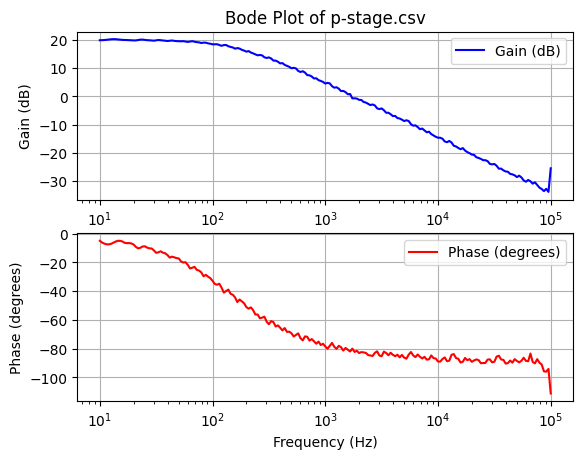

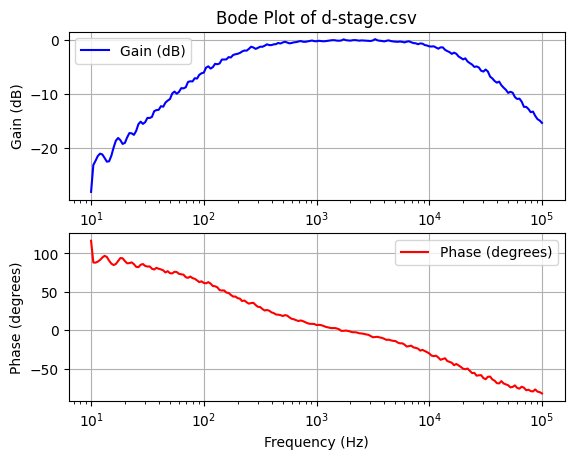

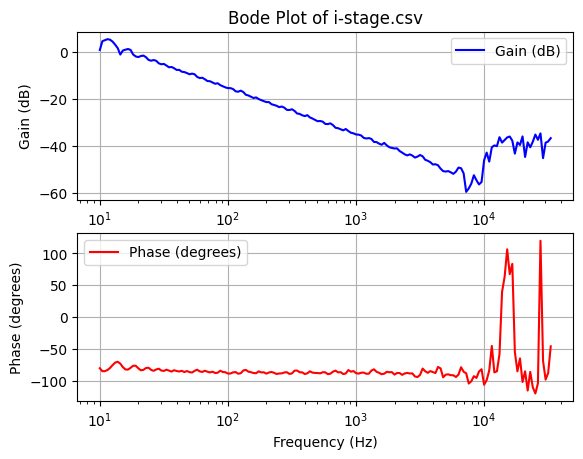

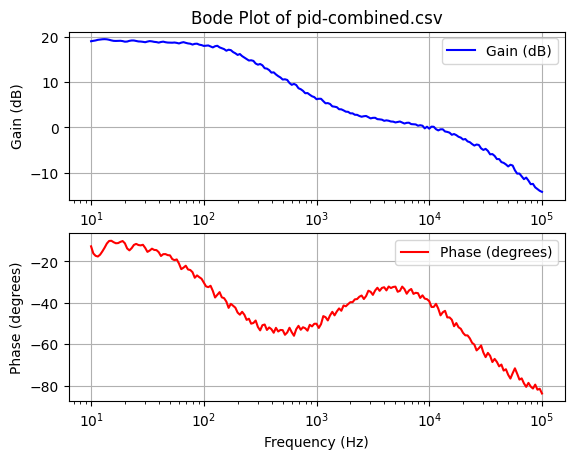

In [3]:
def get_bode_plot(file_name):
    data = np.loadtxt(file_name, delimiter=',')
    title = file_name.replace('.csv', '')
    freq = data[:, 0]  
    gain = data[:, 1]
    phase = data[:,2]
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.semilogx(freq, gain, label='Gain (dB)', color='blue')
    ax1.set_ylabel('Gain (dB)')
    ax1.grid()
    ax1.legend()
    ax1.set_title(f'Bode Plot of {file_name}')
    ax2.semilogx(freq, phase, label='Phase (degrees)', color='red')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase (degrees)')
    ax2.grid()
    ax2.legend()

get_bode_plot('p-stage.csv')
get_bode_plot('d-stage.csv')
get_bode_plot('i-stage.csv')
get_bode_plot('pid-combined.csv')

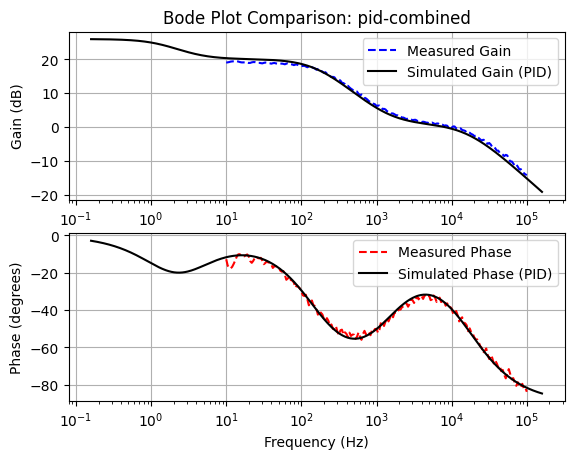

In [7]:
def get_bode_plot_with_overlay(file_name, omega_sim, mag_sim, phase_sim, label_sim):
    data = np.loadtxt(file_name, delimiter=',')
    title = file_name.replace('.csv', '')
    freq_meas = data[:, 0]  # in Hz
    gain_meas = data[:, 1]
    phase_meas = data[:, 2]
    
    freq_as_hz = omega_sim / (2 * np.pi)  

    fig, (ax1, ax2) = plt.subplots(2, 1)
    
    # Gain plot
    ax1.semilogx(freq_meas, gain_meas, label='Measured Gain', color='blue', linestyle='--')
    ax1.semilogx(freq_as_hz, mag_sim, label=f'Simulated Gain ({label_sim})', color='black')
    ax1.set_ylabel('Gain (dB)')
    ax1.set_title(f'Bode Plot Comparison: {title}')
    ax1.grid()
    ax1.legend()

    # Phase plot
    ax2.semilogx(freq_meas, phase_meas, label='Measured Phase', color='red', linestyle='--')
    ax2.semilogx(freq_as_hz, phase_sim, label=f'Simulated Phase ({label_sim})', color='black')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase (degrees)')
    ax2.grid()
    ax2.legend()

    plt.show()

get_bode_plot_with_overlay('pid-combined.csv', omega, mag_pid, phase_pid, 'PID')
